In [1]:
print("ok")

ok


In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv("cleaneddata.csv")
df.head()

,NUM_LIQUIDITY_REMOVES,INACTIVITY_STATUS,DURATION,LOG_TOTAL_ADDED_LIQUIDITY,LOG_TOTAL_REMOVED_LIQUIDITY,LOG_ADD_TO_REMOVE_RATIO
0,2.0,Active,0.021829,4.886029,3.660468,1.497298
1,2.0,Active,0.021829,20.287435,20.431681,0.623623
2,1.0,Active,0.171817,15.427966,2.014898,13.556170
3,2.0,Active,0.193160,15.424950,9.459408,5.968181
4,4.0,Active,0.234896,1.292939,3.419606,0.085660


In [3]:
#Now let's split the data to features and target(X,Y)
X = df.drop('INACTIVITY_STATUS', axis=1)
y = df['INACTIVITY_STATUS']
y.head()

0    Active
1    Active
2    Active
3    Active
4    Active
Name: INACTIVITY_STATUS, dtype: object

**NOw let's do some feature transformation**
#First we will ordinal encode our traget column
#we will transform some columns in our dataset for better gradient descent

In [4]:
y= np.where(y=='Active', 1,0)

In [5]:
y

array([1, 1, 1, ..., 1, 1, 1], shape=(20872,))

In [6]:
X.columns

Index(['NUM_LIQUIDITY_REMOVES', 'DURATION', 'LOG_TOTAL_ADDED_LIQUIDITY',
       'LOG_TOTAL_REMOVED_LIQUIDITY', 'LOG_ADD_TO_REMOVE_RATIO'],
      dtype='object')

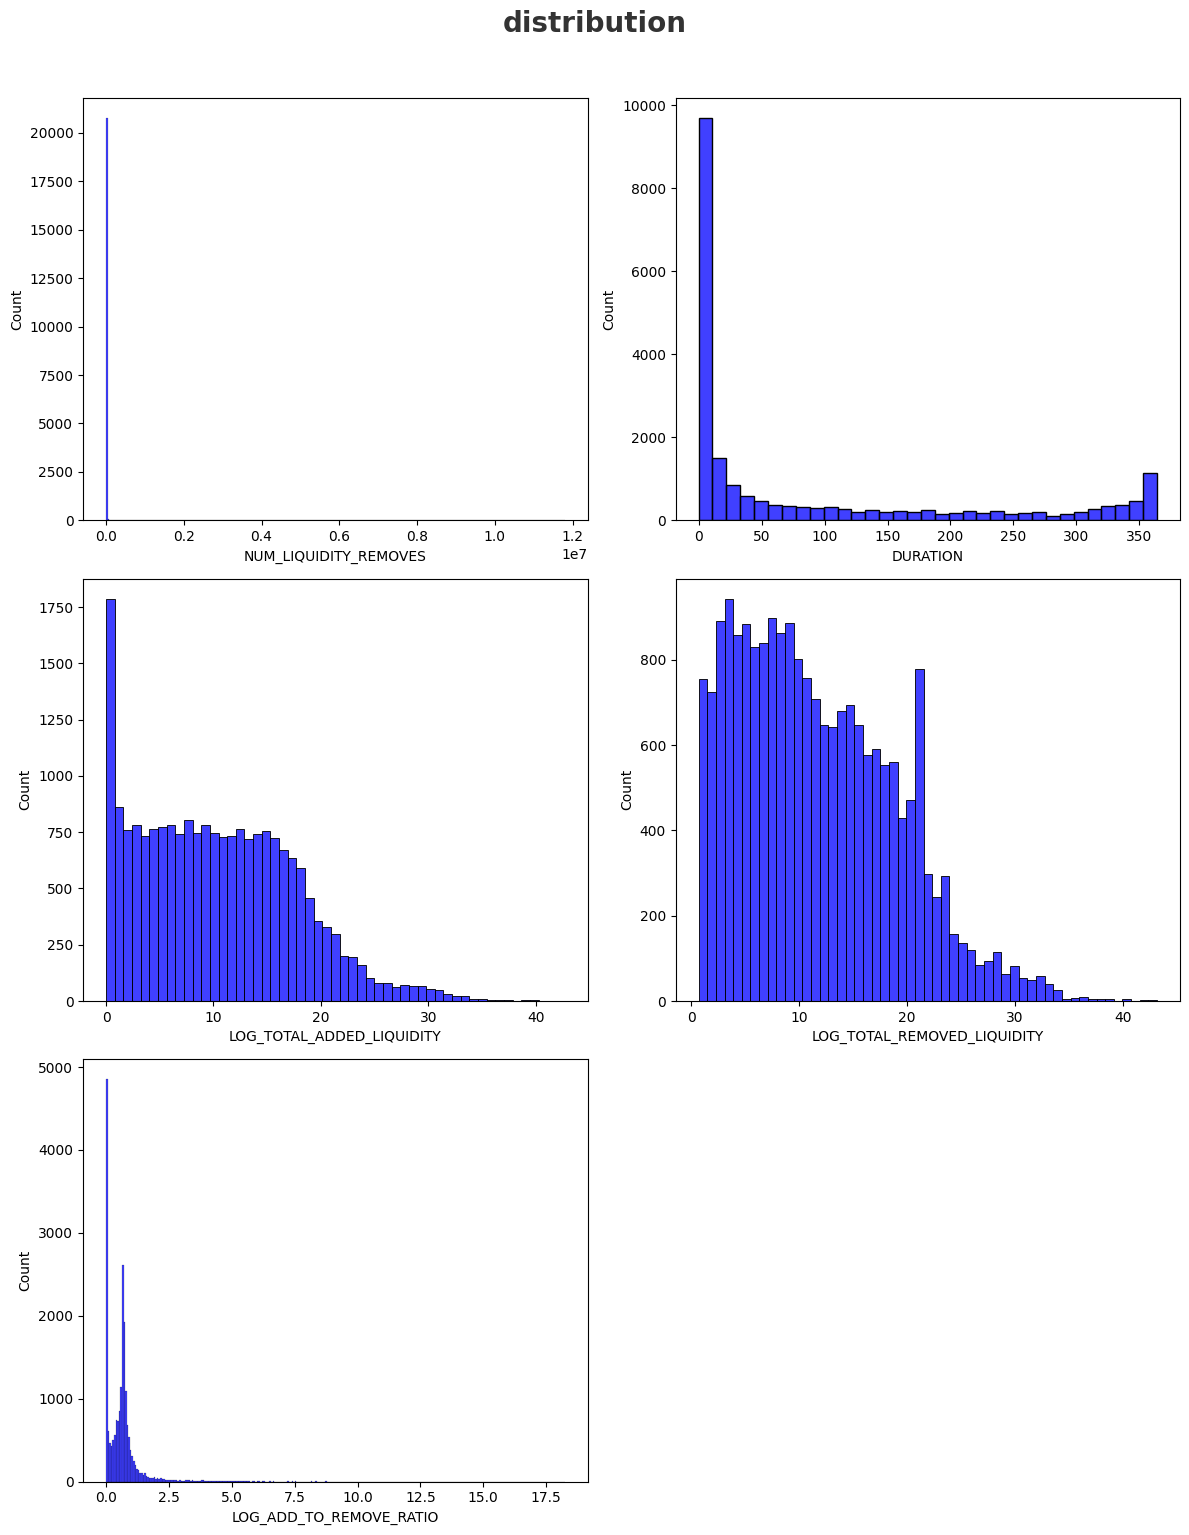

In [7]:
# distribution of data before scaling
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline
n = len(list(X.columns))
rows = math.ceil(n / 2)  # 2 plots per row, adjust if you want 3 per row
plt.figure(figsize=(12, 5 * rows))
plt.suptitle('distribution', fontsize=20, fontweight='bold', alpha=0.8, y=1.02)

for i, col in enumerate(list(X.columns)):
    plt.subplot(rows, 2, i+1)
    sns.histplot(x=X[col], color='blue')
    plt.xlabel(col)
    plt.tight_layout()

plt.tight_layout()
plt.show()
    

In [8]:
# Check Skewness
X[list(X.columns)].skew(axis=0, skipna=True)

NUM_LIQUIDITY_REMOVES          61.987818
DURATION                        1.185808
LOG_TOTAL_ADDED_LIQUIDITY       0.528809
LOG_TOTAL_REMOVED_LIQUIDITY     0.599363
LOG_ADD_TO_REMOVE_RATIO         5.395736
dtype: float64

In [9]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['NUM_LIQUIDITY_REMOVES', 'LOG_ADD_TO_REMOVE_RATIO']
X_copy = pt.fit_transform(X[transform_features])

In [10]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

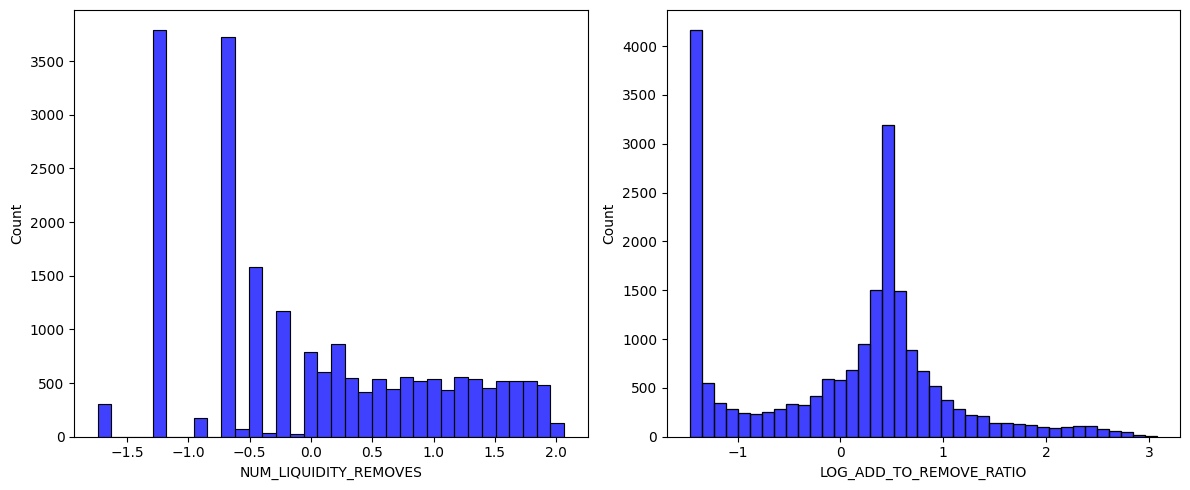

In [11]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=X_copy[col], color='blue')
    plt.xlabel(col)
    plt.tight_layout()

In [12]:
X_copy.skew(axis=0, skipna=True)

NUM_LIQUIDITY_REMOVES      0.338040
LOG_ADD_TO_REMOVE_RATIO    0.032974
dtype: float64

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories** 
* Ordinal encoding is used here as label encoder is supported for column transformer.
* Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

**Standard Scaler** 
* Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**
* Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

In [13]:
num_features = list(X.select_dtypes(exclude="object").columns)

In [14]:
num_features

['NUM_LIQUIDITY_REMOVES',
 'DURATION',
 'LOG_TOTAL_ADDED_LIQUIDITY',
 'LOG_TOTAL_REMOVED_LIQUIDITY',
 'LOG_ADD_TO_REMOVE_RATIO']

In [15]:
# Create Column Transformer with 3 types of transformers

transform_columns= ['LOG_ADD_TO_REMOVE_RATIO','NUM_LIQUIDITY_REMOVES']

from sklearn.preprocessing import  StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()


transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [16]:
X = preprocessor.fit_transform(X)

In [17]:
X

array([[ 1.35183398e+00, -1.24122191e+00, -2.51613180e-02, ...,
        -7.58111134e-01, -1.09992851e+00,  8.66518063e-01],
       [ 3.28189149e-01, -1.24122191e+00, -2.51613180e-02, ...,
         1.37499400e+00,  1.19761612e+00, -5.50569648e-02],
       [ 2.98931183e+00, -1.73830099e+00, -2.51676957e-02, ...,
         7.01954190e-01, -1.32536057e+00,  1.35865250e+01],
       ...,
       [ 6.68966575e-01,  1.99680370e+00,  7.64877127e-01, ...,
         2.79910333e+00,  2.54901798e+00,  1.72272333e-01],
       [ 4.14100435e-01,  2.06495172e+00,  7.52020015e+01, ...,
         1.39377297e+00,  1.20196443e+00, -2.81286897e-03],
       [ 4.67726977e-01,  2.06495172e+00,  7.52020015e+01, ...,
         9.45108475e-01,  7.49259277e-01,  3.14075733e-02]],
      shape=(20872, 7))

LET'S HANDLE IMBALANCE OF OUR DATA BEFORE TRAINING USING 
SMOOTE TECHNIQUE(Synthetic Minority Over-sampling Technique)
**It creates new synthetic samples of the minority class by interpolating between existing samples.

**Helps balance the dataset by increasing minority class size, without just duplicating rows.

Example:
If you have two minority points A and B, SMOTE may create a new point C somewhere on the line segment between A and B.

In [19]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

LET'S DO A TRAIN TEST SPLIT OPERATION ON OUR DATASET

In [20]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((21086, 7), (5272, 7))

In [22]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [23]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [24]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [25]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

In [26]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9659
- F1 score: 0.9632
- Precision: 0.9667
- Recall: 0.9596
- Roc Auc Score: 0.9655


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9437
- F1 score: 0.9387
- Precision: 0.9507
- Recall: 0.9270
- Roc Auc Score: 0.9426


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9161
- F1 score: 0.9107
- Precision: 0.9079
- Recall: 0.9135
- Roc Auc Score: 0.9160
----------------------------------
Model performance for Test set
- Accuracy: 0.9116
- F1 score: 0.9049
- Precision: 0.9063
- Recall: 0.9034
- Roc Auc Score: 0.9111


Logistic Regression
Model performance for Training 

In [27]:
base_model_report

,Model Name,Accuracy
4,K-Neighbors Classifier,0.972117
0,Random Forest,0.965857
5,XGBClassifier,0.952011
6,CatBoosting Classifier,0.945941
1,Decision Tree,0.943665
2,Gradient Boosting,0.911608
7,Support Vector Classifier,0.904970
8,AdaBoost Classifier,0.874810
3,Logistic Regression,0.856032


NOW LET'S DO HYPERPARAMETER TUNNIG OF OUR MODEL

In [28]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [29]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [30]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

c:\Users\PC\Desktop\Allproject\BlockIntel\Mlmodel\Block_intel_model\intel\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\PC\Desktop\Allproject\BlockIntel\Mlmodel\Block_intel_model\intel\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 60 candidates, totalling 180 fits
